In [13]:
import torch
from config import *

In [14]:
from datasets import *
B = 2
shuffle = 1
dataset = ToyDataWithQuestions(split = "train", resolution = (128,128))
dataloader = DataLoader(dataset, batch_size = B, shuffle = shuffle)


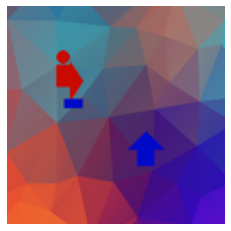

In [15]:
# [Get A Sample Data]
for sample in dataloader:
    sample = sample
plt.axis("off")
plt.imshow(sample["image"][0])

In [16]:
def collect_qa_batch(batch_qa):
    batch_wise_qa = []
    for b in range(len(batch_qa[0]["program"])):
        questions_in_batch = {"question":[],"program":[],"answer":[]}
        for qpair in batch_qa:
            questions_in_batch["question"].append(qpair["question"][b])
            questions_in_batch["program"].append(qpair["program"][b])
            questions_in_batch["answer"].append(qpair["answer"][b])
        batch_wise_qa.append(questions_in_batch)
    return batch_wise_qa

collect_qa_batch(sample["question"])

[{'question': ['is there any boat are there?',
   'is there any house are there?',
   'is there any boat are there?',
   'how many boat are there?',
   'how many house are there?',
   'how many objects are there?'],
  'program': ['exist(filter(scene(),boat))',
   'exist(filter(scene(),house))',
   'exist(filter(scene(),boat))',
   'count(filter(scene(),boat))',
   'count(filter(scene(),house))',
   'count(scene())'],
  'answer': ['yes', 'yes', 'yes', 'one', 'one', 'three']},
 {'question': ['is there any house are there?',
   'is there any boat are there?',
   'is there any house are there?',
   'how many tower are there?',
   'how many house are there?',
   'how many objects are there?'],
  'program': ['exist(filter(scene(),house))',
   'exist(filter(scene(),boat))',
   'exist(filter(scene(),house))',
   'count(filter(scene(),tower))',
   'count(filter(scene(),house))',
   'count(scene())'],
  'answer': ['yes', 'no', 'yes', 'zero', 'one', 'one']}]

In [17]:
def visualize_tree(scores, connections, scale = 1.2):
    fig = plt.figure("tree-visualize",frameon = False)
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    plt.axis("off")
    x_locs = []; y_locs = []
    for i,score in enumerate(reversed(scores)):
        num_nodes = len(score)
        # calculate scores each node
        #print(score.sigmoid())
        #score = (score.sigmoid() + 0.5).int()
        #scores = score.sigmoid()
        score = torch.clamp(score,0.05,1)

        y_positions = [-scale*(i+1) / 2.0] * num_nodes
        x_positions = np.linspace(-scale**(i+1), scale**(i+1), num_nodes)
        if num_nodes == 1: x_positions = [0.0]
        x_locs.append(x_positions); y_locs.append(y_positions)
        
        plt.scatter(x_positions, y_positions, alpha = score, color = 'white', linewidths=2.0)
    for k,connection in enumerate(reversed(connections)):
        connection = connection
        
        lower_node_num = len(x_locs[k])
        upper_node_num = len(x_locs[k+1])
        for i in range(lower_node_num):
            for j in range(upper_node_num):
                plt.plot( [x_locs[k][i],x_locs[k+1][j]], [y_locs[k][i], y_locs[k+1][j]], color = "white" ,alpha = float(connection[j][i]))
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

def answer_distribution_binary(score, name = "answer_distribution"):
    batch_size = 1
    score_size = 4

    row = batch_size * score_size 
    col = row / 2

    scores = [score, 1 - score]

    plt.figure("dists", frameon = False, figsize = (row,col))
    plt.tick_params(left = True, right = False , labelleft = True ,
                labelbottom = True, bottom = True)
    plt.cla()
    
    for i in range(batch_size):
        plt.subplot(1,batch_size,i + 1,frameon=False)
        plt.cla()

        
        keys = ["yes","no"]
        plt.bar(keys,scores)
        plt.tick_params(left = True, right = False , labelleft = True ,
                labelbottom = True, bottom = True)

    plt.savefig("outputs/{}.png".format(name))

In [18]:
config.perception = "valkyr"
model = SceneLearner(config)


In [19]:
def evaluate_pose(x, att):
    x = x.permute(0,2,1)
    # x: B3N, att: B1KN1
    # ts: B3k1
    pai = att.sum(dim=3, keepdim=True) # B1K11
    att = att / torch.clamp(pai, min=1e-3)
    ts = torch.sum(
        att * x[:, :, None, :, None], dim=3) # B3K1
    return ts

def equillibrium_loss(att):
    pai = att.sum(dim=3, keepdim=True) # B1K11
    loss_att_amount = torch.var(pai.reshape(pai.shape[0], -1), dim=1).mean()
    return loss_att_amount


def spatial_variance(x, att, norm_type="l2"):
    
    pai = att.sum(dim=3, keepdim=True) # B1K11
    att = att / torch.clamp(pai, min=1e-3)
    ts = torch.sum(
        att * x[:, :, None, :, None], dim=3) # B3K1

    x_centered = x[:, :, None] - ts # B3KN
    x_centered = x_centered.permute(0, 2, 3, 1) # BKN3
    att = att.squeeze(1) # BKN1
    cov = torch.matmul(
        x_centered.transpose(3, 2), att * x_centered) # BK33
    
    # l2 norm
    vol = torch.diagonal(cov, dim1=-2, dim2=-1).sum(2) # BK
    if norm_type == "l2":
        vol = vol.norm(dim=1).mean()
    elif norm_type == "l1":
        vol = vol.sum(dim=1).mean()
    else:
        # vol, _ = torch.diagonal(cov, dim1=-2, dim2=-1).sum(2).max(dim=1)
        raise NotImplementedError
    return vol

In [22]:
import torch
import torch.nn as nn
from types import SimpleNamespace

class GraphConvolution(nn.Module):

    def __init__(self, input_feature_num, output_feature_num, add_bias=True, dtype=torch.float,
                 batch_normal=True):
        super().__init__()
        # shapes

        self.input_feature_num = input_feature_num
        self.output_feature_num = output_feature_num
        self.add_bias = add_bias
        self.batch_normal = batch_normal

        # params
        self.weight = nn.Linear( input_feature_num, self.output_feature_num)
        self.bias = nn.Parameter(torch.zeros(self.output_feature_num,dtype=dtype))
        self.transform = nn.Linear(self.output_feature_num, self.output_feature_num)
        
        self.sparse = True
        #self.batch_norm = nn.BatchNorm1d(num_features = input_feature_num)
            
    def set_trainable(self, train=True):
        for param in self.parameters():
            param.requires_grad = train

    def forward(self, x, adj):
        """
        @param inp : adjacent: (batch, graph_num, graph_num) cat node_feature: (batch, graph_num, in_feature_num) -> (batch, graph_num, graph_num + in_feature_num)
        @return:
        """
        B, N, D = x.shape
        node_feature = x

        x = self.weight(node_feature)
        #x = torch.nn.functional.normalize(x,p = 1.0, dim = -1, eps = 1e-5)

        if self.sparse or isinstance(adj, torch.SparseTensor):
            x = torch.spmm(adj,x[0]).unsqueeze(0)
        else:
            x = torch.matmul(adj,x[0])
        #if self.add_bias:
        #x = x + self.bias.unsqueeze(0).unsqueeze(0).repeat(B,N,1)

        #x = self.transform(x)

        #x = torch.nn.functional.normalize(x,p = 1.0, dim = -1, eps = 1e-5)

        return x

class GNNSoftPooling(nn.Module):
    def __init__(self, input_feat_dim, output_node_num = 10):
        super().__init__()
        self.assignment_net = GraphConvolution(input_feat_dim, output_node_num)
        self.feature_net =   GraphConvolution(input_feat_dim, input_feat_dim) 
    
    def forward(self, x, adj):
        B,N,D = x.shape
        # B,N,N = adj.shape
        if isinstance(adj, list):
            output_node_features = []
            output_new_adj = []
            output_s_matrix = []
            for i in range(len(adj)):
                s_matrix = self.assignment_net(x[i:i+1], adj[i]) #[B,N,M]
                
                s_matrix = torch.softmax(s_matrix , dim = 2)#.clamp(0.0+eps,1.0-eps)
            
                node_features = self.feature_net(x[i:i+1],adj[i]) #[B,N,D]
                node_features = torch.einsum("bnm,bnd->bmd",s_matrix,node_features) #[B,M,D]
                # [Calculate New Cluster Adjacency]

                adj[i] = torch.Tensor.to_dense(adj[i])
                #print("smt,adj",s_matrix.max(),s_matrix.min(), adj[i].max(), adj[i].min())
                #print(adj[i].shape, s_matrix.shape)
                new_adj = torch.spmm(
                    torch.spmm(
                        s_matrix[0].permute(1,0),adj[i]
                        ),s_matrix[0])
                #print("new_adj",new_adj[i].max(), new_adj[i].min())

                output_node_features.append(node_features)
                output_new_adj.append(new_adj)
                output_s_matrix.append(s_matrix)

            output_node_features = torch.cat(output_node_features, dim = 0)
            output_s_matrix = torch.cat(output_s_matrix, dim = 0)
        return output_node_features,output_new_adj,output_s_matrix

def get_fourier_feature(grid, term = 7):
    output_feature = []
    for k in range(term):
        output_feature.append(torch.sin(grid * (k + 1)))
        output_feature.append(torch.cos(grid * (k + 1)))
    output_feature = torch.cat(output_feature, dim = -1)
    return output_feature

class ObjectRender(nn.Module):
    def __init__(self,config,conv_feature_dim):
        super().__init__()
        channel_dim = config.channel
        spatial_dim = config.spatial_dim
        fourier_dim = config.fourier_dim

        self.conv_feature_dim = conv_feature_dim
        self.render_block  = FCBlock(128,2,conv_feature_dim + spatial_dim + spatial_dim + 2*spatial_dim*fourier_dim,channel_dim)

    def forward(self, latent, grid):
        B,N,D = latent.shape
        if len(grid.shape) == 4:
            # grid: [B,W,H,2]
            B, W, H, _ = grid.shape
            expand_latent = latent.unsqueeze(2).unsqueeze(2)
            expand_latent = expand_latent.repeat(1,1,W,H,1)
            grid = grid.unsqueeze(1)
            grid = grid.repeat(1,N,1,1,1)
        if len(grid.shape) == 3:
            # grid: [B,WH,2]
            B, WH, _ = grid.shape
            grid = grid.unsqueeze(1).repeat(1,N,1,1)
            expand_latent = latent.unsqueeze(2).repeat(1,1,WH,1)
        cat_feature = torch.cat([grid, expand_latent], dim = -1)
        return self.render_block(cat_feature)


class ValkyrNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        device = config.device
        # construct the grid domain connection
        self.imsize = config.imsize
        self.perception_size = config.perception_size
        # build the connection graph for the grid domain
        self.spatial_coords = grid(self.imsize,self.imsize,device=device)
        self.spatial_fourier_features = get_fourier_feature(self.spatial_coords, term = config.fourier_dim)
        self.spatial_edges =  build_perception(self.imsize,self.perception_size,device = device)
        # [Grid Convs]
        conv_feature_dim = config.conv_feature_dim
        self.grid_convs = RDN(SimpleNamespace(G0=conv_feature_dim  ,RDNkSize=3,n_colors=3,RDNconfig=(4,3,16),scale=[2],no_upsampling=True))
        
        # [Diff Pool Construction]
        hierarchy_nodes = config.hierarchy_construct 
        self.diff_pool = nn.ModuleList([
            GNNSoftPooling(input_feat_dim = conv_feature_dim+2,output_node_num = node_num ) for node_num in hierarchy_nodes
        ])
        

        # [Render Fields]
        self.render_fields = nn.ModuleList([ObjectRender(config, conv_feature_dim) for _ in hierarchy_nodes])

        self.conv2object_feature = nn.Linear(conv_feature_dim + 2, config.object_dim)
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
    
    def forward(self, x, verbose = 0):
        outputs = {}
        B,W,H,C = x.shape # input shape

        # [Grid Convolution] produce initial feature in the grid domain 
        grid_conv_feature = self.grid_convs(x.permute(0,3,1,2))
        _,_,_,D = grid_conv_feature.shape
        coords_added_conv_feature = torch.cat(
            [grid_conv_feature, self.spatial_coords.unsqueeze(0).repeat(B,1,1,1)], dim = 3
        )
        if verbose:print("coords_added_conv_feature:{}x{}x{}x{}".format(*list(coords_added_conv_feature.shape) ))

        coords_added_conv_feature = coords_added_conv_feature.reshape(B,W*H,(D+2))
        coords_added_conv_feature = F.normalize(coords_added_conv_feature, dim = -1)
       
        # [DiffPool] each layer performs differentiable [Pn invariant] pooling 

        convs_features = []
        cluster_assignments = []
        curr_x = coords_added_conv_feature # base layer feature
  
        curr_edges = [self.spatial_edges for _ in range(B)] # base layer edges
        convs_features.append(curr_x)
        entropy_regular = 0.0 # initialize the entropy loss
        loc_loss = 0.0        # localization loss
        equi_loss = 0.0       # equillibrium loss
        scene_tree = {
            "x":[curr_x],
            "object_features":[self.conv2object_feature(curr_x)],
            "object_scores":[torch.ones(B,curr_x.shape[1]).to(self.device)],
            "connections":[],
            "edges":[self.spatial_edges]}

        layer_reconstructions = []
        layer_masks = [torch.ones(B,curr_x.shape[1]).to(self.device)]  # maintain a mask
        for i,graph_pool in enumerate(self.diff_pool):
            curr_x, curr_edges, assignment_matrix = graph_pool(curr_x, curr_edges)
            B,N,M = assignment_matrix.shape
            assignment_matrix = torch.min(scene_tree["object_scores"][-1].unsqueeze(2).repeat(1,1,M), assignment_matrix)

            # previous level mask calculation
            prev_mask = layer_masks[-1]
            #print(prev_mask.shape, assignment_matrix.shape)
            if len(prev_mask.shape) == 2:
                layer_mask = assignment_matrix #[BxNxWxHx1]
            else:layer_mask = torch.bmm(prev_mask,assignment_matrix)
            layer_masks.append(layer_mask)
            #print(layer_mask.shape)
            exist_prob = torch.max(assignment_matrix,dim = 1).values
            
            cluster_assignments.append(assignment_matrix)
            convs_features.append(curr_x)

            # [Scene Reconstruction]
            syn_grid = torch.cat([self.spatial_coords ,self.spatial_fourier_features], dim = -1).unsqueeze(0).repeat(B,1,1,1)

            layer_recons = self.render_fields[i](
                curr_x,
                syn_grid
                )

            if verbose: print("reconstruction with shape: ", layer_recons.shape)
            layer_reconstructions.append(layer_recons)
            
            if verbose:print(assignment_matrix.max(),assignment_matrix.min(), curr_edges[0].shape, curr_edges[0].max(), curr_edges[0].min())
            
            # [Regular Entropy Term]
            
            attention_mask = layer_mask
            points = self.spatial_coords.unsqueeze(0).repeat(B,1,1,1).reshape(B,W*H,2)
            #pose_locals = evaluate_pose(points , attention_mask)
            #loc_loss += spatial_variance(points, attention_mask, norm_type="l2")
            #equi_loss += equillibrium_loss(attention_mask)

            entropy_regular += assignment_entropy(assignment_matrix)

            # load results to the scene tree
            scene_tree["x"].append(curr_x)
            scene_tree["object_features"].append(self.conv2object_feature(curr_x))
            scene_tree["object_scores"].append(exist_prob)
            scene_tree["connections"].append(assignment_matrix)
            scene_tree["edges"].append(curr_edges)

        # [Calculate Reconstruction at Each Layer]
        outputs["reconstructions"] = []
        reconstruction_loss = 0.0

        for i,recons in enumerate(layer_reconstructions):

            B,N,W,H,C = recons.shape

            exist_prob = scene_tree["object_scores"][i+1]\
                .unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).repeat(1,1,W,H,C) 

            mask = layer_masks[i+1].permute(0,2,1).reshape(B,N,W,H,1)

            recons = recons * mask * exist_prob
            
            layer_recon_loss = torch.nn.functional.mse_loss(recons, x.unsqueeze(1).repeat(1,N,1,1,1))
            reconstruction_loss += layer_recon_loss


        # [Output the Scene Tree]
        outputs["scene_tree"] = scene_tree

        # [Add all the loss terms]
        outputs["losses"] = {"entropy":entropy_regular,"reconstruction":reconstruction_loss}
        return outputs

def assignment_entropy(s_matrix):
    # s_matrix: B,N,M
    EPS = 1e-6
    output_entropy = 0
    for i in range(s_matrix.shape[-1]):
        input_tensor = s_matrix[:i,:].clamp(EPS, 1-EPS)
        lsm = nn.LogSoftmax(dim = -1)
        log_probs = lsm(input_tensor)
        probs = torch.exp(log_probs)
        p_log_p = log_probs * probs
        entropy = -p_log_p.mean()
        output_entropy += entropy
    output_entropy = 0.0
    return output_entropy
    
def localization_loss(adj, s_matrix):
    pass

def build_perception(size,length,device):
    edges = [[],[]]
    for i in range(size):
        for j in range(size):
            # go for all the points on the grid
            coord = [i,j];loc = i * size + j

            for dx in range(-length,length+1):
                for dy in range(-length,length+1):
                    if i+dx < size and i+dx>=0 and j+dy<size and j+dy>=0:
                        if (i+dx) * size + (j + dy) != loc:
                            edges[0].append(loc)
                            edges[1].append( (i+dx) * size + (j + dy))
    outputs = torch.sparse_coo_tensor(edges, torch.ones(len(edges[0])), size = (size**2, size**2))
    return outputs.to(device)

def grid(width, height, device = "cuda:0" if torch.cuda.is_available() else "cpu"):
    x = torch.linspace(0,1,width)
    y = torch.linspace(0,1,height)
    grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')
    return torch.cat([grid_x.unsqueeze(0),grid_y.unsqueeze(0)], dim = 0).permute(1,2,0)
    

In [23]:
config.perception_size = 3
config.hierarchy_construct = [7,5,3]
model.scene_perception = ValkyrNet(config)

perception_outputs = model.scene_perception(sample["image"])
scene_tree = perception_outputs["scene_tree"]

In [24]:

def build_scene_tree(perception_outputs):
    all_kwargs = []
    scene_tree = perception_outputs["scene_tree"]
    scores = scene_tree["object_scores"]
    features = scene_tree["object_features"]
    connections = scene_tree["connections"]

    B = features[0].shape[0]
    for b in range(B):
        kw_scores, kw_features, kw_connections = [score[b] for score in scores], [feature[b] for feature in features], \
        [connection[b] for connection in connections]
        kwargs = {"features":kw_features, "end":kw_scores, "connections":kw_connections}
        all_kwargs.append(kwargs)
    return all_kwargs


In [25]:
scene_tree = perception_outputs["scene_tree"]

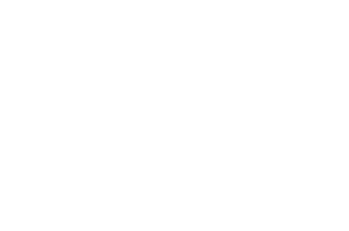

In [26]:
b = 1
vis_scores = [score[b].detach() for score in scene_tree["object_scores"][1:]]
vis_connections = [connect[b] for connect in scene_tree["connections"][1:]]


visualize_tree(vis_scores, vis_connections, scale = 1.618)


/var/folders/tp/c2bzzvd17y35z8x_20mfhn700000gn/T/ipykernel_33112/63699579.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,batch_size,i + 1,frameon=False)


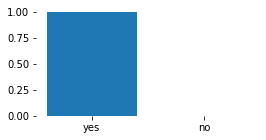

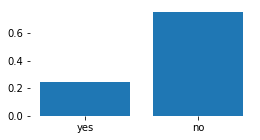

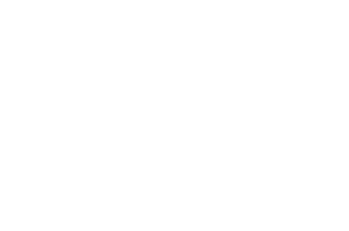

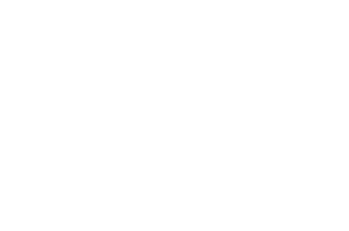

In [31]:
# [Visualize Predicate Segmentation]
batch_kwargs = build_scene_tree(perception_outputs)
#model.executor.effective_level = 3
programs = ["exist(scene())","exist(filter(scene(),house))"]
for b in range(B):
    kwargs = batch_kwargs[b]

    q = programs[b]
    q = model.executor.parse(q)
    o = model.executor(q, **kwargs)
    # [Visualize the Output Mask Scene Tree]
    answer_distribution_binary(o["end"].sigmoid().cpu().detach())
    plt.show()


programs = ["scene()","filter(scene(),house)"]
for b in range(B):
    kwargs = batch_kwargs[b]
    q = programs[b]
    q = model.executor.parse(q)
    o = model.executor(q, **kwargs)

    # [Visualize the Output Mask Scene Tree]
    vis_connections = [connect[b] for connect in scene_tree["connections"][1:]]
    vis_scores = [o["end"][i].sigmoid().cpu().detach() for i in range(4)][1:]
    
    visualize_tree(vis_scores, vis_connections, scale = 1.618)
    plt.show()

#masks = calculate_masks()


[0.       0.       0.993806]
[0.       0.       0.993806 0.       0.      ]
[0.05550702 0.2816416  0.11439623 0.16999325 0.15767348 0.1887217
 0.993806  ]
Max: 0.98899245262146 Min: 0.4079931676387787


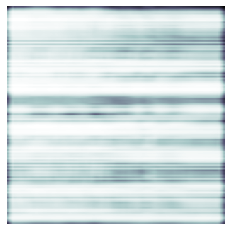

Max: 0.982866644859314 Min: 0.4054660499095917


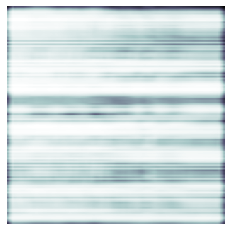

Max: 0.9767787456512451 Min: 0.4029546082019806


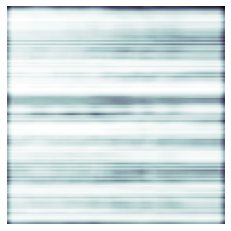

/var/folders/tp/c2bzzvd17y35z8x_20mfhn700000gn/T/ipykernel_33112/173325719.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,N,i + 1)


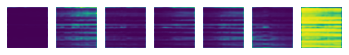

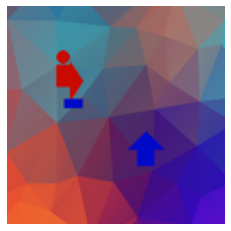

In [32]:
def calculate_masks(scores, connections):
    all_masks = []
    for i in range(len(connections)):
        curr_mask = scores[i+1].unsqueeze(-1)
        for connection in reversed(connections[:i+1]):
            curr_mask = torch.bmm(connection, curr_mask) # [BxNxM],[BxM]
        all_masks.append(curr_mask)
    return all_masks

vis_score = scene_tree["object_scores"]
#vis_score[-1][0][1] = 0.5
print(vis_score[-1][0].cpu().detach().numpy())
print(vis_score[-2][0].cpu().detach().numpy())
print(vis_score[-3][0].cpu().detach().numpy())
all_masks = calculate_masks(vis_score,scene_tree["connections"])

for mask in all_masks:
    plt.axis("off")
    plt.imshow(mask[0].reshape(128,128).detach(), cmap = "bone")
    print("Max:",float(mask[0].max()),"Min:",float(mask[0].min()))
    plt.show()

plt.axis("off")
mask = scene_tree["connections"][0].reshape(2,128,128,7).detach()
N = 7
for i in range(N):
    plt.subplot(1,N,i + 1)
    plt.axis("off")
    plt.imshow(mask[0,:,:,i])
    plt.axis("off")
plt.show()

plt.axis("off")
plt.imshow(sample["image"][0])

In [51]:
def assignment_entropy(s_matrix):
    # s_matrix: B,N,M
    EPS = 1e-6
    output_entropy = 0
    for i in range(s_matrix.shape[-1]):
        input_tensor = s_matrix[i:i+1,:].clamp(EPS, 1-EPS)

        lsm = nn.LogSoftmax(dim = -1)
        log_probs = lsm(input_tensor)
        probs = torch.exp(log_probs)
        p_log_p = log_probs * probs
        entropy = -p_log_p.mean()
        #print(entropy)
        output_entropy += entropy

    return output_entropy
    
def localization_loss(adj, s_matrix):
    pass

s_matrix = torch.tensor([
    [1.0,0.0],
    [0.0,1.0],
])

entropy_loss = assignment_entropy(s_matrix)
print(entropy_loss)

loc_loss = localization_loss(s_matrix)
print(loc_loss)

tensor([[-0.2290, -0.3532]])
tensor([[-0.3532, -0.2290]])
tensor(0.5822)


In [ ]:
from utils.render import *


H, W = (64, 64)
K = ((1, 0, 2),
     (0, 1, 2),
     (0, 0, 1))

c2w = torch.tensor([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
])

rays_o, rays_d = get_rays(H, W, K, c2w, 0, 0, 0)

dirs torch.Size([64, 64, 3])
rays_d torch.Size([64, 64, 3])
rays_o torch.Size([64, 64, 3])


/Users/melkor/miniforge3/envs/Melkor/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
